Initializing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
from xgboost import XGBClassifier

/home/mostafamokhtar743/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Loading datasets

In [21]:
df = pd.read_csv("kepler1.csv", comment='#')
df.shape


(9564, 83)

Data Processing

In [22]:
print(df.columns.tolist())


['rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_disposition', 'koi_vet_stat', 'koi_vet_date', 'koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_disp_prov', 'koi_comment', 'koi_period', 'koi_time0bk', 'koi_time0', 'koi_eccen', 'koi_longp', 'koi_impact', 'koi_duration', 'koi_ingress', 'koi_depth', 'koi_ror', 'koi_srho', 'koi_fittype', 'koi_prad', 'koi_sma', 'koi_incl', 'koi_teq', 'koi_insol', 'koi_dor', 'koi_limbdark_mod', 'koi_ldm_coeff4', 'koi_ldm_coeff3', 'koi_ldm_coeff2', 'koi_ldm_coeff1', 'koi_parm_prov', 'koi_max_sngle_ev', 'koi_max_mult_ev', 'koi_model_snr', 'koi_count', 'koi_num_transits', 'koi_tce_plnt_num', 'koi_tce_delivname', 'koi_quarters', 'koi_bin_oedp_sig', 'koi_trans_mod', 'koi_model_dof', 'koi_model_chisq', 'koi_datalink_dvr', 'koi_datalink_dvs', 'koi_steff', 'koi_slogg', 'koi_smet', 'koi_srad', 'koi_smass', 'koi_sage', 'koi_sparprov', 'ra', 'dec', 'koi_kepmag', 'koi_gmag', 'koi_rmag', 'koi_imag', 'koi_zmag', 

In [23]:
base_features = [
    # --- Orbital ---
    'koi_period',
    'koi_duration',
    'koi_depth',
    'koi_impact',

    # --- Planetary ---
    'koi_prad',
    'koi_teq',
    'koi_insol',

    # --- Stellar (recommended) ---
    'koi_steff',
    'koi_srad',

    # --- Observation ---
    'koi_model_snr'
]

# --- Engineered features ---
df["planet_star_radius_ratio"] = df["koi_prad"] / df["koi_srad"]
df["insolation_temp_ratio"] = df["koi_insol"] / df["koi_teq"]
df["log_period"] = np.log1p(df["koi_period"])
df["log_snr"] = np.log1p(df["koi_model_snr"])
df["depth_duration_ratio"] = df["koi_depth"] / df["koi_duration"]
df["duration_period_ratio"] = df["koi_duration"] / df["koi_period"]
df["normalized_depth"] = df["koi_depth"] / (df["koi_model_snr"] + 1)
df["impact_depth_product"] = df["koi_impact"] * df["koi_depth"]

features = base_features + [
    "planet_star_radius_ratio",
    "insolation_temp_ratio",
    "log_period",
    "log_snr",
    "depth_duration_ratio",
    "duration_period_ratio",
    "normalized_depth",
    "impact_depth_product"
]


In [24]:
target = "koi_disposition"

df = df[features + [target]].dropna()

X = df[features]
y = df[target]

X = X.fillna(X.median(numeric_only=True))


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

le = LabelEncoder()
y = le.fit_transform(y)


print("Classes:", le.classes_)

Classes: ['CANDIDATE' 'CONFIRMED' 'FALSE POSITIVE']


Train/Test Split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

Training Model

In [26]:
model = XGBClassifier(subsample=1, reg_lambda=1, n_estimators=500, min_child_weight=1, max_depth=6, learning_rate=0.01, gamma=0, colsample_bytree=0.9)
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

Evaluation

Accuracy: 0.7859858772406301

Classification Report:
                 precision    recall  f1-score   support

     CANDIDATE       0.58      0.54      0.56       375
     CONFIRMED       0.83      0.86      0.84       549
FALSE POSITIVE       0.84      0.84      0.84       917

      accuracy                           0.79      1841
     macro avg       0.75      0.75      0.75      1841
  weighted avg       0.78      0.79      0.78      1841



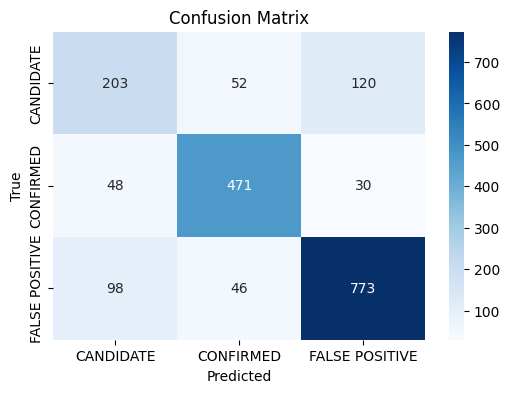

In [27]:
y_pred = model.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Saving Model

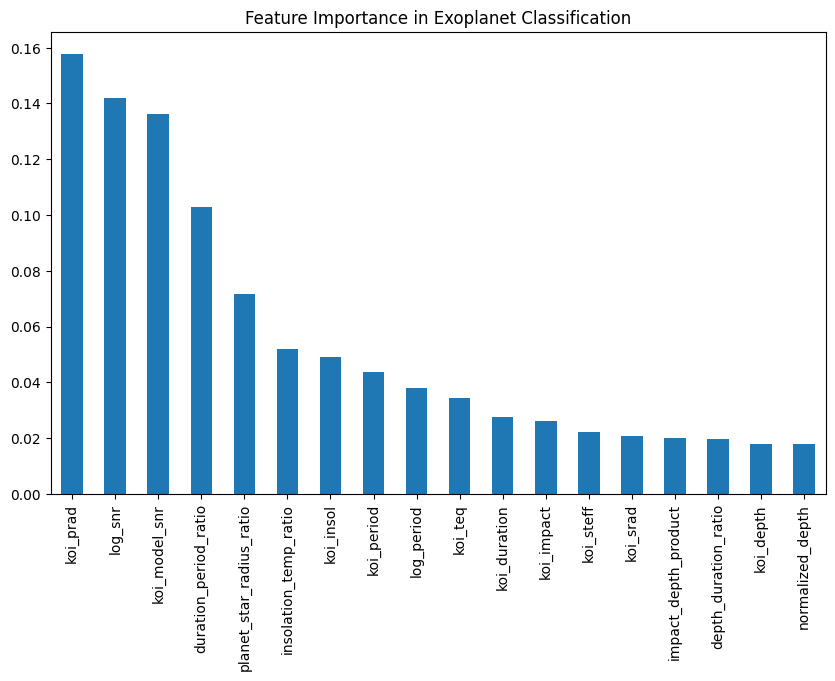

In [28]:
feat_importance = pd.Series(model.feature_importances_, index=X.columns)
feat_importance.sort_values(ascending=False).plot(kind='bar', figsize=(10,6))
plt.title("Feature Importance in Exoplanet Classification")
plt.show()

In [ ]:
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

In [29]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=15)
X_new = selector.fit_transform(X, y)